In [2]:
import os
import numpy as np
import cv2
import transformations
import scipy.io as sio
import glob
from PIL import Image
from PIL import ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy
import tensorflow as tf
import sys
import data_generation
import networks
import param
import util
import truncated_vgg
from keras.backend.tensorflow_backend import set_session
from keras.optimizers import Adam

Using TensorFlow backend.


In [28]:
vid_info_list = data_generation.make_vid_info_list('/mnt/data/jarvislam1999/posewarp-cvpr2018/data/test')

In [29]:
len(vid_info_list)

1

In [30]:
bbox=np.array(vid_info_list[0][1])

In [31]:
bbox[0]

array([ 687.64548803,  125.95119705,  205.08287293,  433.73848987])

In [32]:
pose=np.array(vid_info_list[0][2])

In [33]:
params = param.get_general_params()

In [34]:
params

{'IMG_HEIGHT': 256,
 'IMG_WIDTH': 256,
 'obj_scale_factor': 1.14,
 'scale_max': 1.05,
 'scale_min': 0.9,
 'max_rotate_degree': 5,
 'max_sat_factor': 0.05,
 'max_px_shift': 10,
 'posemap_downsample': 2,
 'sigma_joint': 1.75,
 'n_joints': 14,
 'n_limbs': 10,
 'limbs': [[0, 1],
  [2, 3],
  [3, 4],
  [5, 6],
  [6, 7],
  [8, 9],
  [9, 10],
  [11, 12],
  [12, 13],
  [2, 5, 8, 11]],
 'n_training_iter': 200000,
 'test_interval': 500,
 'model_save_interval': 1000,
 'project_dir': '/mnt/data/jarvislam1999/posewarp-cvpr2018',
 'model_save_dir': '/mnt/data/jarvislam1999/posewarp-cvpr2018/models',
 'data_dir': '/mnt/data/jarvislam1999/posewarp-cvpr2018/data',
 'batch_size': 1}

In [35]:
# warp generator
img_width = params['IMG_WIDTH']
img_height = params['IMG_HEIGHT']
pose_dn = params['posemap_downsample']
sigma_joint = params['sigma_joint']
n_joints = params['n_joints']
scale_factor = params['obj_scale_factor']
batch_size = params['batch_size']
limbs = params['limbs']
n_limbs = params['n_limbs']

output_generator_warp = []

In [36]:
x_src = np.zeros((batch_size, img_height, img_width, 3))
x_mask_src = np.zeros((batch_size, img_height, img_width, n_limbs + 1))
x_pose_src = np.zeros((batch_size, int(img_height / pose_dn), int(img_width / pose_dn), n_joints))
x_pose_tgt = np.zeros((batch_size, int(img_height / pose_dn), int(img_width / pose_dn), n_joints))
x_trans = np.zeros((batch_size, 2, 3, n_limbs + 1))
x_posevec_src = np.zeros((batch_size, n_joints * 2))
x_posevec_tgt = np.zeros((batch_size, n_joints * 2))
y = np.zeros((batch_size, img_height, img_width, 3))

In [37]:
# 1. choose random video.
vid = np.random.choice(len(vid_info_list), 1)[0]

vid_bbox = vid_info_list[vid][1]
vid_x = vid_info_list[vid][2]
vid_path = vid_info_list[vid][3]

In [38]:
# 2. choose pair of frames
n_frames = vid_x.shape[2]
frames = np.array([0,4])
while abs(frames[0] - frames[1]) / (n_frames * 1.0) <= 0.02:
    frames = np.random.choice(n_frames, 2, replace=False)

In [39]:
frames

array([0, 4])

In [40]:
os.path.join(vid_path, str(frames[0] + 1) + '.jpg') == '/mnt/data/jarvislam1999/posewarp-cvpr2018/data/train/frames/Flavia Pennetta in 4k/1.jpg'

False

In [41]:
vid_path

'/mnt/data/jarvislam1999/posewarp-cvpr2018/data/test/frames/Golf Lessons - Stop Topping Fairway Woods'

In [23]:
vid_x[:,:,0]

array([[ 751.29189687,  125.95119705],
       [ 756.00644567,  203.7412523 ],
       [ 706.50368324,  239.10036832],
       [ 687.64548803,  290.96040516],
       [ 725.36187845,  302.74677716],
       [ 807.8664825 ,  210.81307551],
       [ 857.36924494,  253.24401473],
       [ 892.72836096,  298.03222836],
       [ 723.00460405,  349.89226519],
       [ 732.43370166,  465.39871087],
       [ 748.93462247,  559.68968692],
       [ 786.65101289,  361.6786372 ],
       [ 786.65101289,  474.82780847],
       [ 720.64732965,  547.90331492]])

In [42]:
vid_info_list[0][1]

array([[ 687.64548803,  125.95119705,  205.08287293,  433.73848987],
       [ 652.28637201,  118.87937385,  169.72375691,  497.38489871],
       [ 635.7854512 ,  130.66574586,  169.72375691,  469.09760589],
       [ 621.64180479,  140.09484346,  150.86556169,  438.45303867],
       [ 673.50184162,  142.45211786,  106.07734807,  424.30939227],
       [ 623.99907919,  128.30847145,  124.93554328,  445.52486188],
       [ 697.07458564,  125.95119705,  157.9373849 ,  464.38305709],
       [ 657.00092081,  137.73756906,  132.00736648,  447.88213628]])

In [83]:
vid_info_list[0][1] = [[120,230,250,370], \
                       [185,230,290,370], \
                       [380,230,290,370], \
                       [635,230,220,370], \
                       [795,95,245,345], \
                       [990,170,210,340], \
                       [1130,270,160,340],\
                       [1200,220,120,370]]
vid_info_list[0][1] = np.array(vid_info_list[0][1], dtype=np.uint8)

vid_x[:,:,0] = [[ 260,  260],\
                [ 247,  305 ],\
                [ 245,  300],\
                [ 310,  320],\
                [ 350,  300],\
                [ 240,  310],\
                [ 250,  370],\
                [ 300,  400],\
                [ 220,  425],\
                [ 220,  425],\
                [ 200,  490],\
                [ 220,  500 ],\
                [ 140,  550],\
                [ 190,  570]]
vid_x[:,:,0] = np.array(vid_x[:,:,0], dtype = np.uint8)


vid_x[:,:,4] = [[ 890,  100],\
                [ 900,  135 ],\
                [ 885,  160],\
                [ 860,  105],\
                [ 820,  140],\
                [ 940,  140],\
                [ 990,  190],\
                [ 1020,  170],\
                [ 910,  260],\
                [ 880,  340],\
                [ 800,  390],\
                [ 940,  275 ],\
                [ 930,  340],\
                [ 917,  420]]
vid_x[:,:,4] = np.array(vid_x[:,:,4], dtype = np.uint8)

vid_bbox = vid_info_list[vid][1]
vid_x = vid_info_list[vid][2]
vid_path = '/mnt/data/jarvislam1999/posewarp-cvpr2018/data/test001/'

In [84]:
I0, joints0, scale0, pos0 = data_generation.read_frame(vid_path, frames[0], vid_bbox, vid_x)
I1, joints1, scale1, pos1 = data_generation.read_frame(vid_path, frames[1], vid_bbox, vid_x)

In [85]:
print(I0)

[[[192 204 216]
  [193 205 217]
  [193 205 217]
  ..., 
  [138 153 169]
  [147 162 178]
  [152 167 183]]

 [[193 205 217]
  [193 205 217]
  [193 205 217]
  ..., 
  [137 152 168]
  [145 160 176]
  [153 168 184]]

 [[193 205 217]
  [193 205 217]
  [193 205 217]
  ..., 
  [136 151 167]
  [141 156 172]
  [153 168 184]]

 ..., 
 [[ 82 156 212]
  [ 82 156 212]
  [ 81 155 211]
  ..., 
  [132 199 238]
  [133 198 237]
  [133 198 237]]

 [[ 81 156 212]
  [ 81 156 212]
  [ 81 155 211]
  ..., 
  [132 199 238]
  [134 199 238]
  [134 199 238]]

 [[ 81 156 212]
  [ 81 156 212]
  [ 81 155 211]
  ..., 
  [132 199 238]
  [134 199 238]
  [135 200 239]]]


In [89]:
vid_info_list[0][1] = [[120,230,250,370], \
                       [185,230,290,370], \
                       [380,230,290,370], \
                       [635,230,220,370], \
                       [795,95,245,345], \
                       [990,170,210,340], \
                       [1130,270,160,340],\
                       [1200,220,120,370]]
vid_info_list[0][1] = np.array(vid_info_list[0][1], dtype=np.uint8)

vid_x[:,:,0] = [[ 260,  260],\
                [ 247,  305 ],\
                [ 245,  300],\
                [ 310,  320],\
                [ 350,  300],\
                [ 240,  310],\
                [ 250,  370],\
                [ 300,  400],\
                [ 220,  425],\
                [ 220,  425],\
                [ 200,  490],\
                [ 220,  500 ],\
                [ 140,  550],\
                [ 190,  570]]
vid_x[:,:,0] = np.array(vid_x[:,:,0], dtype = np.uint8)


vid_x[:,:,4] = [[ 890,  100],\
                [ 900,  135 ],\
                [ 885,  160],\
                [ 860,  105],\
                [ 820,  140],\
                [ 940,  140],\
                [ 990,  190],\
                [ 1020,  170],\
                [ 910,  260],\
                [ 880,  340],\
                [ 800,  390],\
                [ 940,  275 ],\
                [ 930,  340],\
                [ 917,  420]]
vid_x[:,:,4] = np.array(vid_x[:,:,4], dtype = np.uint8)

vid_bbox = vid_info_list[vid][1]
vid_x = vid_info_list[vid][2]
vid_path = '/mnt/data/jarvislam1999/posewarp-cvpr2018/data/test001/'

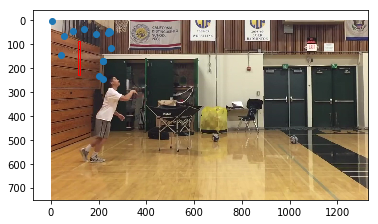

In [90]:
#img_01 = Image.open(vid_path + '/1.png')
img_01 = Image.open(vid_path + '/scene00011.jpg')

img_01 = np.array(img_01, dtype=np.uint8)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(img_01)

# Create a Rectangle patch
rect = patches.Rectangle((vid_info_list[0][1][0][0],\
                          vid_info_list[0][1][0][1]),\
                         vid_info_list[0][1][0][2],\
                         vid_info_list[0][1][0][3],linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
plt.scatter(vid_x[:,0,0], vid_x[:,1,0])


#plt.imshow(cv2.cvtColor(I0, cv2.COLOR_BGR2RGB))
plt.show()

In [91]:
vid_info_list[0][1][0]

array([120, 230, 250, 114], dtype=uint8)

In [92]:
vid_x[:,:,0]

array([[   4.,    4.],
       [ 247.,   49.],
       [ 245.,   44.],
       [  54.,   64.],
       [  94.,   44.],
       [ 240.,   54.],
       [ 250.,  114.],
       [  44.,  144.],
       [ 220.,  169.],
       [ 220.,  169.],
       [ 200.,  234.],
       [ 220.,  244.],
       [ 140.,   38.],
       [ 190.,   58.]])

In [93]:
do_augment = False
if scale0 > scale1:
    scale = scale_factor / scale0
else:
    scale = scale_factor / scale1

pos = (pos0 + pos1) / 2.0
print(I0)
I0 = np.array(I0, dtype=np.uint8)
print(I0.shape)
I0, joints0 = data_generation.center_and_scale_image(I0, img_width, img_height, pos, scale, joints0)
I1, joints1 = data_generation.center_and_scale_image(I1, img_width, img_height, pos, scale, joints1)
print(I0.shape)

[[[192 204 216]
  [193 205 217]
  [193 205 217]
  ..., 
  [138 153 169]
  [147 162 178]
  [152 167 183]]

 [[193 205 217]
  [193 205 217]
  [193 205 217]
  ..., 
  [137 152 168]
  [145 160 176]
  [153 168 184]]

 [[193 205 217]
  [193 205 217]
  [193 205 217]
  ..., 
  [136 151 167]
  [141 156 172]
  [153 168 184]]

 ..., 
 [[ 82 156 212]
  [ 82 156 212]
  [ 81 155 211]
  ..., 
  [132 199 238]
  [133 198 237]
  [133 198 237]]

 [[ 81 156 212]
  [ 81 156 212]
  [ 81 155 211]
  ..., 
  [132 199 238]
  [134 199 238]
  [134 199 238]]

 [[ 81 156 212]
  [ 81 156 212]
  [ 81 155 211]
  ..., 
  [132 199 238]
  [134 199 238]
  [135 200 239]]]
(752, 1328, 3)
(256, 256, 3)


In [94]:
print(I0[0,0,:])

[0 0 0]


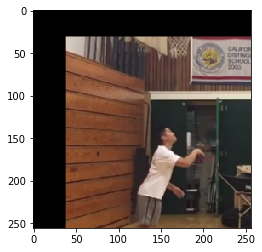

In [95]:
plt.imshow(cv2.cvtColor(I0, cv2.COLOR_BGR2RGB))
plt.show()

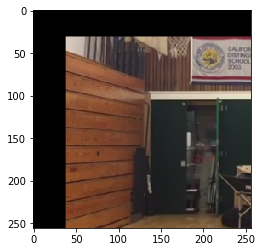

In [96]:
plt.imshow(cv2.cvtColor(I1, cv2.COLOR_BGR2RGB))
plt.show()

In [21]:
I2 = copy.deepcopy(I1)

In [22]:
I0 = (I0 / 255.0 - 0.5) * 2.0
I1 = (I1 / 255.0 - 0.5) * 2.0
print(I0.shape)

(256, 256, 3)


In [23]:
do_augment = False

#print(I0)
print(I0.shape)
if do_augment:
    rflip, rscale, rshift, rdegree, rsat = data_generation.rand_augmentations(params)
    print(rscale)
    I0, joints0 = data_generation.augment(I0, joints0, rflip, rscale, rshift, rdegree, rsat, img_height, img_width)
    I1, joints1 = data_generation.augment(I1, joints1, rflip, rscale, rshift, rdegree, rsat, img_height, img_width)
    # begin augment transformation
    rflip, rscale, rshift, rdegree, rsat = data_generation.rand_augmentations(params)
    print(rflip)
    print(rscale)
    print(rshift)
    print(rdegree)
    print(rsat)
    #print(I0.shape)
    #I0, joints0 = data_generation.aug_flip(I0, rflip, joints0)
    #I0, joints0 = data_generation.aug_scale(I0, rscale, joints0)
    #I0, joints0 = data_generation.aug_shift(I0, img_width, img_height, rshift, joints0)
    #I0, joints0 = data_generation.aug_rotate(I0, img_width, img_height, rdegree, joints0)
    #I0 = data_generation.aug_saturation(I0, rsat)

    print(I0)

    #I1, joints1 = data_generation.aug_flip(I1, rflip, joints1)
    #I1, joints1 = data_generation.aug_scale(I1, rscale, joints1)
    #I1, joints1 = data_generation.aug_shift(I1, img_width, img_height, rshift, joints1)
    #I1, joints1 = data_generation.aug_rotate(I1, img_width, img_height, rdegree, joints1)
    #I1 = data_generation.aug_saturation(I1, rsat)

posemap0 = data_generation.make_joint_heatmaps(img_height, img_width, joints0, sigma_joint, pose_dn)
posemap1 = data_generation.make_joint_heatmaps(img_height, img_width, joints1, sigma_joint, pose_dn)

src_limb_masks = data_generation.make_limb_masks(limbs, joints0, img_width, img_height)
src_bg_mask = np.expand_dims(1.0 - np.amax(src_limb_masks, axis=2), 2)
src_masks = np.log(np.concatenate((src_bg_mask, src_limb_masks), axis=2) + 1e-10)
#print(I1)
#print(src_bg_mask)

(256, 256, 3)


In [24]:
pose_map = np.sum(posemap0, axis = 2)

In [25]:
pose_map.shape

(128, 128)

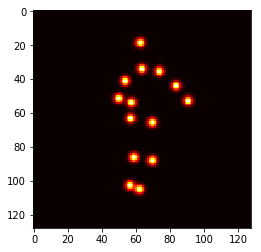

In [26]:
plt.imshow(pose_map, cmap='hot', interpolation='nearest')
plt.show()

In [27]:
x_src[0, :, :, :] = I0
x_pose_src[0, :, :, :] = posemap0
x_pose_tgt[0, :, :, :] = posemap1
x_mask_src[0, :, :, :] = src_masks
x_trans[0, :, :, 0] = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])
x_trans[0, :, :, 1:] = data_generation.get_limb_transforms(limbs, joints0, joints1)

x_posevec_src[0, :] = joints0.flatten()
x_posevec_tgt[0, :] = joints1.flatten()

print(I1.shape)
y[0, :, :, :] = I1
#print(x_src)

(256, 256, 3)


In [28]:
out = [x_src, x_pose_src, x_pose_tgt, x_mask_src, x_trans]

In [29]:
output_generator_warp.append((out,y))

In [30]:
x_in, y_in = output_generator_warp[0]

In [31]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

In [32]:
vgg_model = truncated_vgg.vgg_norm()
networks.make_trainable(vgg_model, False)
response_weights = sio.loadmat('../data/vgg_activation_distribution_train.mat')
model = networks.network_posewarp(params)
model.compile(optimizer=Adam(lr=1e-4), loss=[networks.vgg_loss(vgg_model, response_weights, 12)])

Instructions for updating:
Colocations handled automatically by placer.


In [33]:
#from keras.models import load_weights
model.load_weights('/mnt/data/jarvislam1999/posewarp-cvpr2018/models/vgg_100000.h5')

In [44]:
train_loss = model.train_on_batch(x_in, y_in)

Instructions for updating:
Use tf.cast instead.


/home/jarvislam1999/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [45]:
train_loss

0.2645295

In [96]:
print(y[0].shape)

(256, 256, 3)


In [46]:
y_out = model.predict(x_in, 1)

In [47]:
y_out.shape

(1, 256, 256, 3)

In [48]:
y_out[0].shape

(256, 256, 3)

In [49]:
y_final = copy.deepcopy(y_out[0])

In [50]:
y_final = (y_final/2.0 + 0.5)*255.0
#y_final = (y_final / 255.0 - 0.5) * 2.0

In [51]:
y_final = y_final.astype(int)

In [52]:
y_final_b = copy.deepcopy(y_final[:,:,0])
y_final[:,:,0] = y_final[:,:,2]
y_final[:,:,2] = y_final_b

In [53]:
y_final

array([[[144, 191, 203],
        [167, 213, 239],
        [175, 209, 244],
        ..., 
        [215, 238, 251],
        [219, 236, 249],
        [199, 216, 243]],

       [[153, 193, 226],
        [153, 214, 247],
        [158, 212, 250],
        ..., 
        [209, 242, 253],
        [222, 245, 253],
        [217, 239, 251]],

       [[131, 169, 214],
        [134, 185, 239],
        [149, 197, 246],
        ..., 
        [215, 242, 254],
        [216, 245, 254],
        [225, 241, 252]],

       ..., 
       [[ 63,  92,  38],
        [ 44,  85,  20],
        [ 61, 102,  33],
        ..., 
        [ 67, 110,  43],
        [ 72, 121,  42],
        [ 81, 108,  60]],

       [[ 65,  91,  40],
        [ 37,  77,  13],
        [ 40,  82,  14],
        ..., 
        [ 63, 106,  32],
        [ 67, 115,  35],
        [ 70, 105,  53]],

       [[ 96,  97,  62],
        [ 60,  88,  33],
        [ 59,  91,  31],
        ..., 
        [ 80, 111,  56],
        [ 75, 101,  56],
        [ 76, 106,

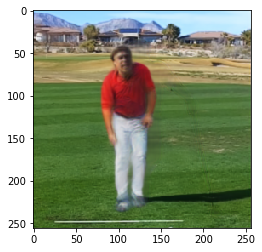

In [54]:
#plt.imshow(cv2.cvtColor(y_final, cv2.COLOR_BGR2RGB))
plt.imshow(y_final)
plt.show()

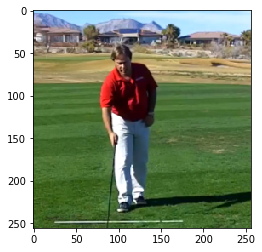

In [55]:
plt.imshow(cv2.cvtColor(I2, cv2.COLOR_BGR2RGB))
plt.show()